### 1. Data

### Graphs setup

Based on the available data, you will create two graphs to model our relationships as follows:

1.Citation graph: This graph should represent the paper's citation relationships. We want this graph to be unweighted and directed. The citation should represent the citation given from one paper to another. For example, if paper A has cited paper B, we should expect an edge from node A to B.

2.Collaboration graph: This graph should represent the collaborations of the paper's authors. This graph should be weighted and undirected. Consider an appropriate weighting scheme for your edges to make your graph weighted.

### Data pre-processing
The dataset is quite large and may not fit in your memory when you try constructing your graph. So, what is the solution? You should focus your investigation on a subgraph. You can work on the most connected component in the graph. However, you must first construct and analyze the connections to identify the connected components.

As a result, you will attempt to approximate that most connected component by performing the following steps:

1.Identify the top 10,000 papers with the highest number of citations.

2.Then the nodes of your graphs would be as follows:

Citation graph: you can consider each of the papers as your nodes

Collaboration graph: the authors of these papers would be your nodes

3.For the edges of the two graphs, you would have the following cases:

Citation graph: only consider the citation relationship between these 10,000 papers and ignore the rest.

Collaboration graph: only consider the collaborations between the authors of these 10,000 papers and ignore the rest.

In [1]:
# first import required libraries:
import pandas as pd
import numpy as np
import ijson
import matplotlib.pyplot as plt
import networkx as nx
import time
import os

In [2]:
json_file_path = r'C:\Users\LENOVO\Desktop\UNI\02-ADM\homework5\dblp.v12.json'

# for dirname, _, filenames in os.walk(json_file_path):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

articles = []
start = time.process_time()

with open(json_file_path, "rb") as f:
    for i, element in enumerate(ijson.items(f, "item")):
        paper1={}

        paper1['id'] = element['id']

        paper1['title'] = element['title']

        authors =element.get('authors')
        if authors:
            paper1['authors'] = authors
        else:
            paper1['authors'] = np.nan

        year = element.get('year')
        if year:
            paper1['year'] = year
        else:
            paper1['year'] = np.nan

        n_citation = element.get('n_citation')
        if n_citation:
            paper1['n_citation'] = element['n_citation']
        else:
            paper1['n_citation'] = 0
            
        references = element.get('references')
        if references:
            paper1['reference_count'] = len(references)
            # joining all refs id in a `;` seperated string
            paper1['references'] = ';'.join([str(int(r)) for r in references])
        else:
            paper1['reference_count'] = np.nan
            paper1['references'] = np.nan

        publisher = element.get('publisher')
        if publisher:
            paper1['publisher'] = element['publisher']
        else:
            paper1['publisher'] = np.nan

        doc_type = element.get('doc_type')
        if doc_type:
            paper1['doc_type'] = element['doc_type']
        else:
            paper1['doc_type'] = np.nan

        articles.append(paper1)
        if i % 46000 == 0:
            print(f"{i}:{round((time.process_time() - start), 2)}s ", end="")
#             break

0:0.0s 46000:3.11s 92000:6.31s 138000:9.28s 184000:12.16s 230000:15.47s 276000:19.89s 322000:24.58s 368000:29.23s 414000:34.03s 460000:38.86s 506000:43.97s 552000:48.7s 598000:53.53s 644000:58.45s 690000:63.55s 736000:68.8s 782000:73.58s 828000:79.41s 874000:85.08s 920000:89.84s 966000:96.25s 1012000:100.92s 1058000:106.56s 1104000:111.89s 1150000:116.77s 1196000:122.34s 1242000:127.58s 1288000:136.03s 1334000:139.86s 1380000:148.98s 1426000:154.45s 1472000:164.89s 1518000:170.45s 1564000:176.09s 1610000:181.2s 1656000:184.75s 1702000:191.22s 1748000:197.44s 1794000:203.45s 1840000:210.92s 1886000:214.78s 1932000:229.86s 1978000:232.94s 2024000:247.48s 2070000:262.25s 2116000:265.98s 2162000:281.61s 2208000:284.41s 2254000:300.7s 2300000:317.39s 2346000:320.73s 2392000:338.39s 2438000:359.19s 2484000:380.14s 2530000:382.89s 2576000:386.38s 2622000:405.08s 2668000:427.97s 2714000:431.31s 2760000:453.39s 2806000:457.33s 2852000:479.0s 2898000:480.77s 2944000:503.22s 2990000:505.42s 30360

In [3]:
len(articles)

4894081

In [4]:
df = pd.DataFrame(articles)
df

,id,title,authors,year,n_citation,reference_count,references,publisher,doc_type
0,1091,Preliminary Design of a Network Protocol Learn...,"[{'name': 'Makoto Satoh', 'org': 'Shinshu Univ...",2013.0,1,2.0,2005687710;2018037215,"Springer, Berlin, Heidelberg",Conference
1,1388,Further Results on Independence in Direct-Prod...,"[{'name': 'Pranava K. Jha', 'id': 2718958994}]",2000.0,1,NaN,NaN,NaN,Journal
2,1674,A methodology for the physically accurate visu...,"[{'name': 'G. Beale', 'org': 'Archaeological C...",2011.0,1,15.0,1535888970;1992876689;1993710814;2035653341;20...,Eurographics Association,Conference
3,1688,"Comparison of GARCH, Neural Network and Suppor...","[{'name': 'Altaf Hossain', 'org': 'Department ...",2009.0,6,3.0,1560724230;1986968751;2156909104,"Springer, Berlin, Heidelberg",Conference
4,5411,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,"[{'name': 'Rafael Álvarez', 'id': 2125293936},...",2009.0,0,NaN,NaN,NaN,Conference
...,...,...,...,...,...,...,...,...,...
4894076,99905544,A Naïve-Bayesian methodology to classify echo ...,"[{'name': 'S. Nandagopalan', 'org': 'Dept. of ...",2010.0,2,8.0,1562217771;1625504505;2015022770;2108751703;21...,"Springer, Berlin, Heidelberg",Conference
4894077,99884553,Blind Equalization for underwater communications,"[{'name': 'Koen Cornelis Hubertus Blom', 'org'...",2014.0,0,NaN,NaN,University of Twente,NaN
4894078,999847014,Technical Implementation and Feasibility,"[{'name': 'Gert Læssøe Mikkelsen', 'org': 'Ale...",2015.0,1,6.0,1940933138;1975620021;1978183200;2097595927;21...,Springer International Publishing,NaN
4894079,9990887,Knowledge Patterns in Databases,"[{'name': 'Rajesh Natarajan', 'org': 'Indian I...",2011.0,0,NaN,NaN,IGI Global,NaN


In [5]:
df.to_csv("citation_network.csv", index=False)

In [7]:
df_sorted = df.sort_values('n_citation', ascending=False)
df_sorted

,id,title,authors,year,n_citation,reference_count,references,publisher,doc_type
4696136,2041404167,The Mathematical Theory of Communication,"[{'name': 'C. E. Shannon', 'org': 'External Or...",1949.0,48327,NaN,NaN,NaN,Book
4630907,1639032689,"Genetic algorithms in search, optimization, an...","[{'name': 'David E. Goldberg', 'id': 2102678951}]",1989.0,44175,NaN,NaN,NaN,Book
4092588,2912565176,Fuzzy sets,"[{'name': 'Lotfi A. Zadeh', 'id': 2252586558}]",1996.0,42437,NaN,NaN,NaN,NaN
2937610,2151103935,Distinctive Image Features from Scale-Invarian...,"[{'name': 'David G. Lowe', 'org': 'Computer Sc...",2004.0,35541,33.0,19720318;1541642243;1560959218;1676552347;1681...,Kluwer Academic Publishers,Journal
4088311,2911964244,Random Forests,"[{'name': 'Leo Breiman', 'org': 'Statistics De...",2001.0,34741,11.0,1507255258;1580948147;1605688901;1975846642;20...,NaN,NaN
...,...,...,...,...,...,...,...,...,...
1443456,2032880371,Rotational sandpile models: A finite size scal...,"[{'name': 'Jahir Abbas Ahmed', 'org': 'Departm...",2011.0,0,NaN,NaN,North-Holland,Journal
3867857,2803206110,Development of a signal-toolkit to increase th...,"[{'name': 'Roman Beneder', 'org': 'Department ...",2018.0,0,NaN,NaN,IEEE,Conference
1443458,2032880699,Intelligent and defensive framework for decisi...,"[{'name': 'Adrian Rusu', 'org': 'Dept. of Comp...",2013.0,0,3.0,2113657762;2137376968;2151012661,IEEE,Conference
1443466,2032881482,Secure and efficient coding of biomedical sign...,"[{'name': 'Óscar J. Rubio', 'org': 'Aragon In...",2014.0,0,3.0,1973675857;2104655872;2270964349,IEEE,Conference


In [95]:
sliced_df = newdf.head(10000)
sliced_df.to_csv('sorted_sliced_10,000_data.csv', index=False)

In [96]:
file_path=r'C:\Users\LENOVO\Desktop\UNI\02-ADM\homework5\sorted_sliced_10,000_data.csv'
df_10000=pd.read_csv(file_path)
df_10000

,id,title,authors,year,n_citation,reference_count,references,publisher,doc_type
0,2041404167,The Mathematical Theory of Communication,"[{'name': 'C. E. Shannon', 'org': 'External Or...",1949.0,48327,NaN,NaN,NaN,Book
1,1639032689,"Genetic algorithms in search, optimization, an...","[{'name': 'David E. Goldberg', 'id': 2102678951}]",1989.0,44175,NaN,NaN,NaN,Book
2,2912565176,Fuzzy sets,"[{'name': 'Lotfi A. Zadeh', 'id': 2252586558}]",1996.0,42437,NaN,NaN,NaN,NaN
3,2151103935,Distinctive Image Features from Scale-Invarian...,"[{'name': 'David G. Lowe', 'org': 'Computer Sc...",2004.0,35541,33.0,19720318;1541642243;1560959218;1676552347;1681...,Kluwer Academic Publishers,Journal
4,2911964244,Random Forests,"[{'name': 'Leo Breiman', 'org': 'Statistics De...",2001.0,34741,11.0,1507255258;1580948147;1605688901;1975846642;20...,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9995,1964830323,An overview of JML tools and applications,"[{'name': 'Lilian Burdy', 'org': 'INRIA Sophia...",2005.0,596,82.0,1486696980;1489778371;1492315860;1498946538;14...,Springer-Verlag,Conference
9996,2060553764,Trust and e-commerce: a study of consumer perc...,"[{'name': 'Brian J. Corbitt', 'org': 'School o...",2003.0,596,7.0,1492586516;1515344919;1572145800;1704743582;17...,Elsevier,Journal
9997,2068691410,Geographic routing in city scenarios,"[{'name': 'Christian Lochert', 'org': 'Heinric...",2005.0,596,4.0,1554193878;2101963262;2151800518;2156689181,ACM,Journal
9998,2147343704,EVENODD: an efficient scheme for tolerating do...,"[{'name': 'M. Blaum', 'org': 'IBM Almaden Rese...",1995.0,596,9.0,1530042190;1531975040;1820898047;1829547464;20...,IEEE Computer Society,Journal


In [98]:
G=nx.DiGraph()

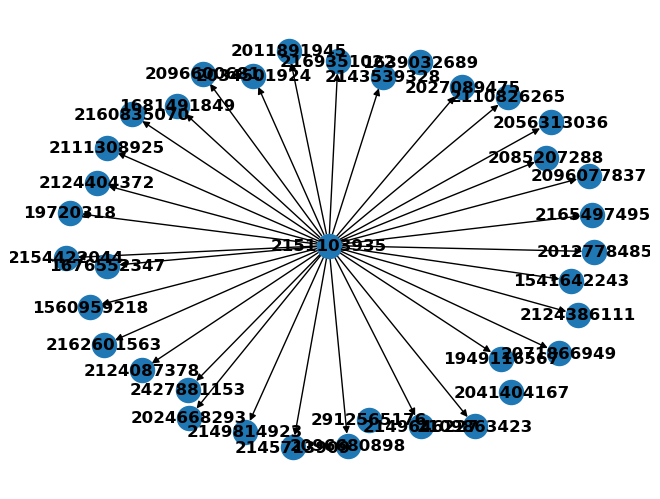

In [99]:
# Citation Graph:
# unweighted and directed.
# nodes: each of the papers as your nodes
# edges: he citation relationship between these 10,000 papers

# Add edges to the graph
for index, row in df_10000.iterrows():
    source_node = row['id']
    
    if type(row['references'])!= float:
        edges=list(map(lambda x:int(x),row['references'].split(';')))
        for target_node in edges:
            G.add_edge(source_node, target_node)
    
    if type(row['references'])== float:
        G.add_node(row['id'])
    
    if index==3:
        break

# Visuali/ze the graph (optional)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
plt.show()

In [92]:
G.nodes()

NodeView((2041404167, 1639032689, 2912565176))

In [93]:
G.edges()

OutEdgeView([])